Failed to get ticker 'QQQ' reason: Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.



=== TRAINING SPECIALISTS WITH ADAPTIVE REWARDS ===
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']


Failed to get ticker 'SPY' reason: Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['^VIX']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']



1 Failed download:
['^VIX']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']



3 Failed downloads:
['NVDA', 'SHY', 'QQQ']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Training trend agent...
Training accumulation agent...
Training crisis agent...
Training Complete.

=== STARTING ADAPTIVE BACKTEST (2024-01-02 to 2025-05-05) ===
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']



3 Failed downloads:
['SPY', 'SHY', 'QQQ']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Date         | Regime          | Agent        | Action | Portfolio 
----------------------------------------------------------------------
2024-01-23   | TREND           | trend        |   0.00 |     100575
2024-02-21   | CRISIS          | crisis       |   0.00 |     100276
2024-03-20   | TREND           | trend        |   0.35 |      99070
2024-04-18   | ACCUMULATION    | accumulation |   0.00 |      98131
2024-05-16   | ACCUMULATION    | accumulation |   0.00 |      98131
2024-06-14   | TREND           | trend        |   1.00 |     117010
2024-07-16   | ACCUMULATION    | accumulation |   0.88 |     114554
2024-08-13   | CRISIS          | crisis       |   0.00 |     108052
2024-09-11   | ACCUMULATION    | accumulation |   0.19 |     108730
2024-10-09   | ACCUMULATION    | accumulation |   0.00 |     120573
2024-11-06   | ACCUMULATION    | accumulation |   0.00 |     122317
2024-12-05   | ACCUMULATION    | accumulation |   1.00 |     126874
2025-01-06   | ACCUMULATION    | accumulation

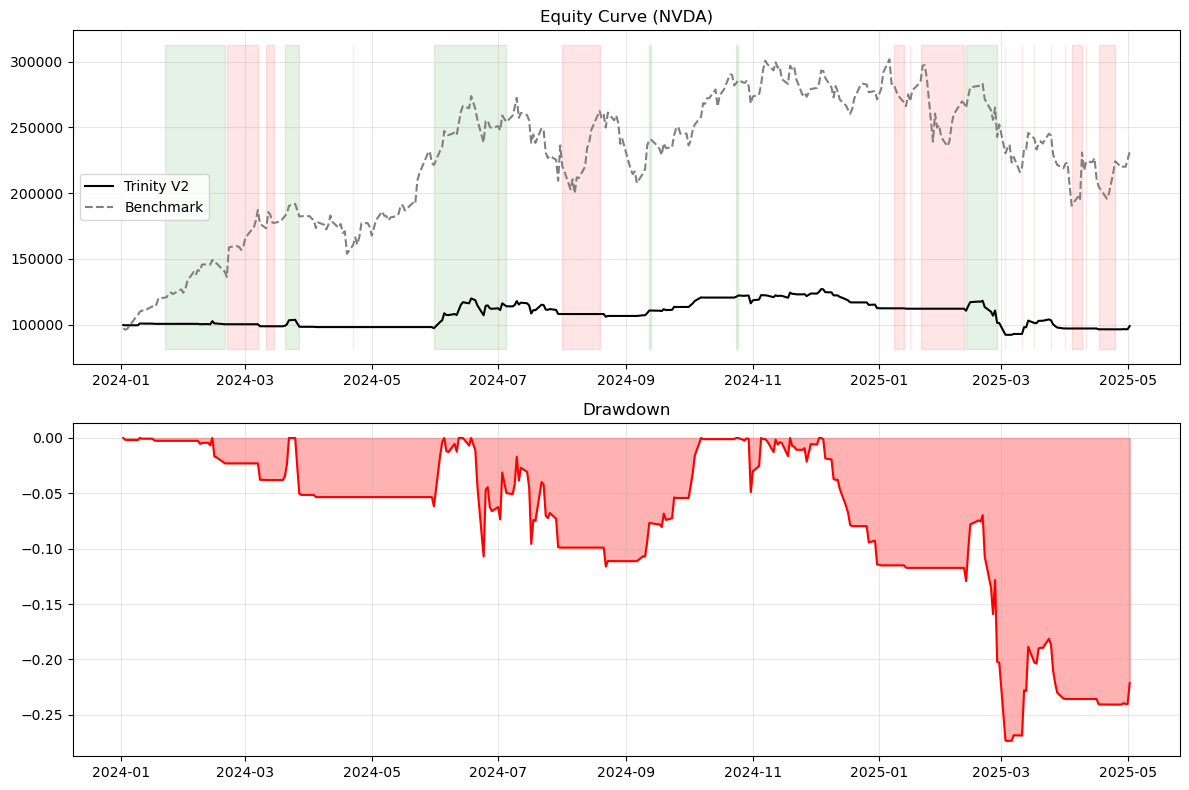

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURATION V2 (ADAPTIVE) ---
DEFAULT_CONFIG = {
    # Assets
    "TICKERS": ["SPY", "QQQ", "^VIX", "SHY"], 
    "TARGET_ASSET": "SPY",
    
    # Dates
    "TRAIN_START": "2015-01-01",
    "TRAIN_END": "2023-12-31",
    "TEST_START": "2024-01-02",
    "TEST_END": "2025-05-05",
    
    # Crisis Training Periods (Fixed dates are okay for training data selection)
    "CRISIS_PERIODS": [
        ("2018-10-01", "2019-01-01"), 
        ("2020-02-01", "2020-05-01"), 
        ("2022-01-01", "2022-12-31"),
    ],
    
    # Adaptive Parameters (No more hard ADX=25)
    "LOOKBACK_WINDOW": 60,       # Window for Z-score calculation
    "REGIME_SENSITIVITY": 0.5,   # Std Dev threshold for regime switching
    
    # RL Params
    "LEARNING_RATE": 3e-4,
    "BATCH_SIZE": 64,
    "TRAINING_STEPS": 60000, 
    "INITIAL_BALANCE": 100000,
    "FEES": 0.001,              # Increased slightly to be realistic
    "MAX_LEVERAGE": 1.0, 
    "LONG_ONLY": False          # Will be auto-set to True for single stocks in run_system
}

# --- DATA PROCESSOR WITH ADAPTIVE FEATURES ---
class AdaptiveDataProcessor:
    def __init__(self, tickers, config):
        self.tickers = list(set(tickers))
        self.config = config
        
    def download(self, start, end):
        try:
            target = self.config['TARGET_ASSET']
            if target not in self.tickers: self.tickers.append(target)
                
            print(f"Fetching data for: {self.tickers}")
            data = yf.download(self.tickers, start=start, end=end, progress=False)
            
            # Handle yfinance multi-index
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]: data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]: data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]: data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series): data = data.to_frame()
            if target not in data.columns: data.columns = [target]
            
            # Get Volume
            ohlc = yf.download(target, start=start, end=end, progress=False)
            if 'Volume' not in data.columns:
                data['Volume'] = ohlc['Volume'] if 'Volume' in ohlc.columns else 1.0
                
            return data, ohlc
        except Exception as e:
            print(f"Data Error: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def add_features(self, df, ohlc):
        target = self.config['TARGET_ASSET']
        if df.empty: return pd.DataFrame()
        
        df = df.copy()
        
        # 1. Basic Returns
        df['returns'] = df[target].pct_change().fillna(0)
        df['log_ret'] = np.log1p(df['returns'])
        
        # 2. Volatility (Realized)
        df['vol_20'] = df['log_ret'].rolling(20).std() * np.sqrt(252)
        
        # 3. Bollinger Bands (Relative)
        sma20 = df[target].rolling(20).mean()
        std20 = df[target].rolling(20).std()
        df['bb_upper'] = sma20 + 2*std20
        df['bb_lower'] = sma20 - 2*std20
        df['pct_b'] = (df[target] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / sma20
        
        # 4. ADX (Trend Strength)
        high = ohlc['High'] if 'High' in ohlc.columns else df[target]
        low = ohlc['Low'] if 'Low' in ohlc.columns else df[target]
        close = ohlc['Close'] if 'Close' in ohlc.columns else df[target]
        
        df['tr'] = np.maximum(high - low, np.maximum(abs(high - close.shift(1)), abs(low - close.shift(1))))
        df['dm_plus'] = np.where((high - high.shift(1)) > (low.shift(1) - low), np.maximum(high - high.shift(1), 0), 0)
        df['dm_minus'] = np.where((low.shift(1) - low) > (high - high.shift(1)), np.maximum(low.shift(1) - low, 0), 0)
        
        window = 14
        df['tr_s'] = df['tr'].rolling(window).mean()
        df['dp_s'] = df['dm_plus'].rolling(window).mean()
        df['dm_s'] = df['dm_minus'].rolling(window).mean()
        df['dx'] = 100 * abs(df['dp_s'] - df['dm_s']) / (df['dp_s'] + df['dm_s'] + 1e-9)
        df['adx'] = df['dx'].rolling(window).mean().fillna(0)

        # 5. Distance from Long Term SMAs
        df['dist_sma50'] = (df[target] / df[target].rolling(50).mean()) - 1
        df['dist_sma200'] = (df[target] / df[target].rolling(200).mean()) - 1
        
        # 6. Lee-Mykland (Jump)
        log_ret = np.log(df[target] / df[target].shift(1))
        bv = (abs(log_ret) * abs(log_ret.shift(1))).rolling(20).mean() * (np.pi/2)
        local_vol = np.sqrt(bv)
        df['l_stat'] = log_ret / (local_vol + 1e-9)

        # --- ADAPTIVE NORMALIZATION (Z-Scores) ---
        # Instead of raw ADX > 25, we use Z-Score > 0.5
        lookback = self.config['LOOKBACK_WINDOW']
        
        # Robust Scaling function
        def rolling_z_score(series, window):
            mean = series.rolling(window).mean()
            std = series.rolling(window).std()
            return (series - mean) / (std + 1e-9)

        df['adx_z'] = rolling_z_score(df['adx'], lookback)
        df['vol_z'] = rolling_z_score(df['vol_20'], lookback)
        df['volume_z'] = rolling_z_score(df['Volume'], lookback)
        
        # Fill NaNs from rolling windows
        df = df.fillna(0)
        return df

    def get_data(self, start, end):
        df, ohlc = self.download(start, end)
        return self.add_features(df, ohlc)

    def get_crisis_data(self):
        dfs = []
        for s, e in self.config['CRISIS_PERIODS']:
            d, o = self.download(s, e)
            dfs.append(self.add_features(d, o))
        return pd.concat(dfs).reset_index(drop=True).fillna(0)

# --- ENVIRONMENT V2 (IMPROVED REWARDS) ---
class AdaptiveTradingEnv(gym.Env):
    def __init__(self, df, config, mode='trend'):
        super().__init__()
        self.df = df
        self.config = config
        self.mode = mode 
        self.window = config['LOOKBACK_WINDOW']
        
        # Observations: normalize logic is handled by wrapper, but we pass raw data
        self.data = df.values.astype(np.float32)
        self.n_features = df.shape[1]
        
        # Actions: [-1, 1] for position sizing
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window * self.n_features,), dtype=np.float32)
        
        self.current_step = self.window
        
        # Feature indices for Reward Calculation
        self.cols = df.columns.tolist()
        self.idx_ret = self.cols.index('returns')
        self.idx_pct_b = self.cols.index('pct_b') if 'pct_b' in self.cols else -1
        self.idx_sma200 = self.cols.index('dist_sma200') if 'dist_sma200' in self.cols else -1
        self.idx_vol = self.cols.index('vol_20')

    def reset(self, seed=None, options=None):
        self.current_step = self.window + np.random.randint(0, 50) # Random start to prevent overfitting
        if self.current_step >= len(self.df): self.current_step = self.window
        return self._get_obs(), {}
    
    def _get_obs(self):
        return self.data[self.current_step-self.window : self.current_step].flatten()

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, False, {}
            
        act = np.clip(action[0], -1, 1)
        ret = self.data[self.current_step, self.idx_ret]
        
        # --- REGIME SPECIFIC REWARD FUNCTIONS ---
        reward = 0
        
        if self.mode == 'trend':
            # Reward: Capture direction of return. 
            # Bonus: Holding position if SMA200 distance is positive (Long term trend alignment)
            reward = act * ret * 100
            sma_dist = self.data[self.current_step, self.idx_sma200]
            if sma_dist > 0 and act > 0: reward += 0.1
            
        elif self.mode == 'accumulation':
            # Mean Reversion Logic
            # Reward BUYING when pct_b < 0.2, Reward SELLING when pct_b > 0.8
            pct_b = self.data[self.current_step, self.idx_pct_b]
            
            pnl = act * ret * 100
            reward = pnl
            
            # Penalize holding exposure in the middle of the band (choppiness)
            if 0.3 < pct_b < 0.7:
                reward -= abs(act) * 0.05 
            
            # Boost mean reversion entries
            if pct_b < 0.1 and act > 0.5: reward += 0.5
            if pct_b > 0.9 and act < -0.5: reward += 0.5

        elif self.mode == 'crisis':
            # Preservation of Capital is #1
            # Reward is PnL, but heavily penalized for drawdowns
            reward = act * ret * 100
            if ret < -0.02 and act > 0.1: # Caught long in a crash
                reward -= 5.0 
            if ret < -0.02 and act < -0.1: # Short/Hedged during crash
                reward += 2.0
                
        self.current_step += 1
        return self._get_obs(), reward, False, False, {}

# --- MANAGER V2 (SOFT SWITCHING) ---
class TrinityManagerV2:
    def __init__(self, config):
        self.config = config
        self.dp = AdaptiveDataProcessor(config['TICKERS'], config)
        self.agents = {}
        self.envs = {}
        
    def train(self):
        print("\n=== TRAINING SPECIALISTS WITH ADAPTIVE REWARDS ===")
        trend_data = self.dp.get_data(self.config['TRAIN_START'], self.config['TRAIN_END'])
        crisis_data = self.dp.get_crisis_data()
        
        for mode in ['trend', 'accumulation', 'crisis']:
            data = crisis_data if mode == 'crisis' else trend_data
            print(f"Training {mode} agent...")
            
            env = DummyVecEnv([lambda: AdaptiveTradingEnv(data, self.config, mode=mode)])
            env = VecNormalize(env, norm_obs=True, norm_reward=False, gamma=0.99)
            
            model = PPO("MlpPolicy", env, verbose=0, 
                        learning_rate=self.config['LEARNING_RATE'], 
                        batch_size=self.config['BATCH_SIZE'])
            
            model.learn(total_timesteps=self.config['TRAINING_STEPS'])
            self.agents[mode] = model
            self.envs[mode] = env
            
        print("Training Complete.")

    def backtest(self, start, end):
        print(f"\n=== STARTING ADAPTIVE BACKTEST ({start} to {end}) ===")
        
        # 1. Prepare Data
        # We need a warmup period for rolling Z-scores to stabilize
        warmup_start = (pd.to_datetime(start) - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
        df = self.dp.get_data(warmup_start, end)
        
        # Slice to actual test period
        test_mask = (df.index >= start) & (df.index <= end)
        test_df = df[test_mask]
        
        if test_df.empty: return
        
        # 2. Setup
        portfolio = self.config['INITIAL_BALANCE']
        benchmark = self.config['INITIAL_BALANCE']
        holdings = 0
        history = []
        
        # Indices for fast access
        vals = df.values # Use full DF for lookback
        cols = df.columns.tolist()
        
        idx_map = {c: i for i, c in enumerate(cols)}
        
        # Offset for indexing into 'vals' based on test_df
        start_idx = np.where(df.index == test_df.index[0])[0][0]
        end_idx = np.where(df.index == test_df.index[-1])[0][0]
        
        sensitivity = self.config['REGIME_SENSITIVITY']
        
        print(f"{'Date':<12} | {'Regime':<15} | {'Agent':<12} | {'Action':<6} | {'Portfolio':<10}")
        print("-" * 70)
        
        for t in range(start_idx, end_idx + 1):
            # Context
            current_date = df.index[t]
            
            # --- ADAPTIVE REGIME DETECTION ---
            # Using Z-scores instead of hard thresholds
            adx_z = vals[t-1, idx_map['adx_z']]
            vol_z = vals[t-1, idx_map['vol_z']]
            l_stat = vals[t-1, idx_map['l_stat']]
            dist_sma200 = vals[t-1, idx_map['dist_sma200']]
            
            regime = "NEUTRAL"
            agent_name = "accumulation" # Default
            
            # 1. Crisis Check (Priority 1)
            # High volatility expansion OR deep below SMA200 OR negative jump
            if (vol_z > 2.0) or (dist_sma200 < -0.15) or (l_stat < -3.0):
                regime = "CRISIS"
                agent_name = "crisis"
                
            # 2. Trend Check (Priority 2)
            # Positive ADX trend AND not in crisis
            elif (adx_z > sensitivity) and (dist_sma200 > -0.05):
                regime = "TREND"
                agent_name = "trend"
                
            # 3. Accumulation (Default)
            # Low ADX, Low Volatility
            else:
                regime = "ACCUMULATION"
                agent_name = "accumulation"
            
            # --- AGENT PREDICTION ---
            # Get observation window
            obs_raw = vals[t - self.config['LOOKBACK_WINDOW'] : t].flatten()
            
            # Normalize using the specific agent's environment statistics
            env = self.envs[agent_name]
            obs_norm = env.normalize_obs(obs_raw)
            
            action, _ = self.agents[agent_name].predict(obs_norm, deterministic=True)
            raw_act = np.clip(action[0], -1, 1)
            
            # --- SAFETY OVERRIDES (Minimal) ---
            # If Long Only, clip negatives
            if self.config['LONG_ONLY']:
                raw_act = max(0, raw_act)
                
            # Hard Stop Loss Override (Global)
            if dist_sma200 < -0.20 and agent_name != 'crisis':
                raw_act = 0.0 # Force out if market is collapsing
                
            # --- EXECUTION ---
            ret = vals[t, idx_map['returns']]
            
            # Position Sizing
            target_pos = raw_act * self.config['MAX_LEVERAGE']
            
            # Costs
            trade_cost = abs(target_pos - holdings) * self.config['FEES']
            holdings = target_pos
            
            daily_pnl = (holdings * ret * portfolio) - (trade_cost * portfolio)
            portfolio += daily_pnl
            benchmark *= (1 + ret)
            
            history.append({
                'Date': current_date,
                'Portfolio': portfolio,
                'Benchmark': benchmark,
                'Regime': regime,
                'Action': raw_act,
                'Return': ret
            })
            
            if t % 20 == 0:
                 print(f"{str(current_date.date()):<12} | {regime:<15} | {agent_name:<12} | {raw_act:>6.2f} | {portfolio:>10.0f}")

        # Summary
        res = pd.DataFrame(history).set_index('Date')
        total_ret = (res['Portfolio'].iloc[-1] / self.config['INITIAL_BALANCE']) - 1
        bench_ret = (res['Benchmark'].iloc[-1] / self.config['INITIAL_BALANCE']) - 1
        
        print("-" * 70)
        print(f"Final Return: {total_ret:.2%}")
        print(f"Benchmark:    {bench_ret:.2%}")
        print(f"Alpha:        {total_ret - bench_ret:.2%}")
        
        self.plot_results(res)
        
    def plot_results(self, df):
        plt.figure(figsize=(12, 8))
        
        # Equity Curve
        plt.subplot(2, 1, 1)
        plt.plot(df.index, df['Portfolio'], label='Trinity V2', color='k')
        plt.plot(df.index, df['Benchmark'], label='Benchmark', color='gray', linestyle='--')
        plt.title(f"Equity Curve ({self.config['TARGET_ASSET']})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Regime Overlay
        y_min, y_max = plt.ylim()
        plt.fill_between(df.index, y_min, y_max, where=(df['Regime'] == 'TREND'), color='green', alpha=0.1, label='Trend')
        plt.fill_between(df.index, y_min, y_max, where=(df['Regime'] == 'CRISIS'), color='red', alpha=0.1, label='Crisis')
        
        # Drawdown
        plt.subplot(2, 1, 2)
        peak = df['Portfolio'].cummax()
        dd = (df['Portfolio'] - peak) / peak
        plt.plot(df.index, dd, color='red', label='Drawdown')
        plt.fill_between(df.index, dd, 0, color='red', alpha=0.3)
        plt.title("Drawdown")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # --- USER SETUP ---
    target_ticker = "NVDA"
    
    config = DEFAULT_CONFIG.copy()
    config['TARGET_ASSET'] = target_ticker
    
    # Auto-detect "Single Stock" mode
    if target_ticker not in ["SPY", "QQQ", "IWM"]:
        config['LONG_ONLY'] = True # Only Longs for single stocks
        config['MAX_LEVERAGE'] = 1.0 # No Leverage
        
    mgr = TrinityManagerV2(config)
    mgr.train()
    mgr.backtest("2024-01-02", "2025-05-05")


=== TRAINING SPECIALISTS (V2.1 ROBUST) ===
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Training Complete.

=== STARTING BACKTEST (2024-01-02 to 2025-05-05) ===
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']



3 Failed downloads:
['SPY', 'SHY', 'QQQ']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Date         | Regime          | Agent        | Action | Portfolio 
----------------------------------------------------------------------
2024-01-23   | TREND           | trend        |   1.00 |     120778
2024-02-21   | TREND           | trend        |   1.00 |     136106
2024-03-20   | TREND           | trend        |   1.00 |     165369
2024-04-18   | ACCUMULATION    | accumulation |   0.64 |     162291
2024-05-16   | ACCUMULATION    | accumulation |   0.00 |     193575
2024-06-14   | TREND           | trend        |   1.00 |     243162
2024-07-16   | ACCUMULATION    | accumulation |   1.00 |     228743
2024-08-13   | CRISIS          | crisis       |   0.00 |     214088
2024-09-11   | TREND           | trend        |   1.00 |     221549
2024-10-09   | ACCUMULATION    | accumulation |   1.00 |     245594
2024-11-06   | ACCUMULATION    | accumulation |   1.00 |     272379
2024-12-05   | ACCUMULATION    | accumulation |   1.00 |     271854
2025-01-06   | ACCUMULATION    | accumulation

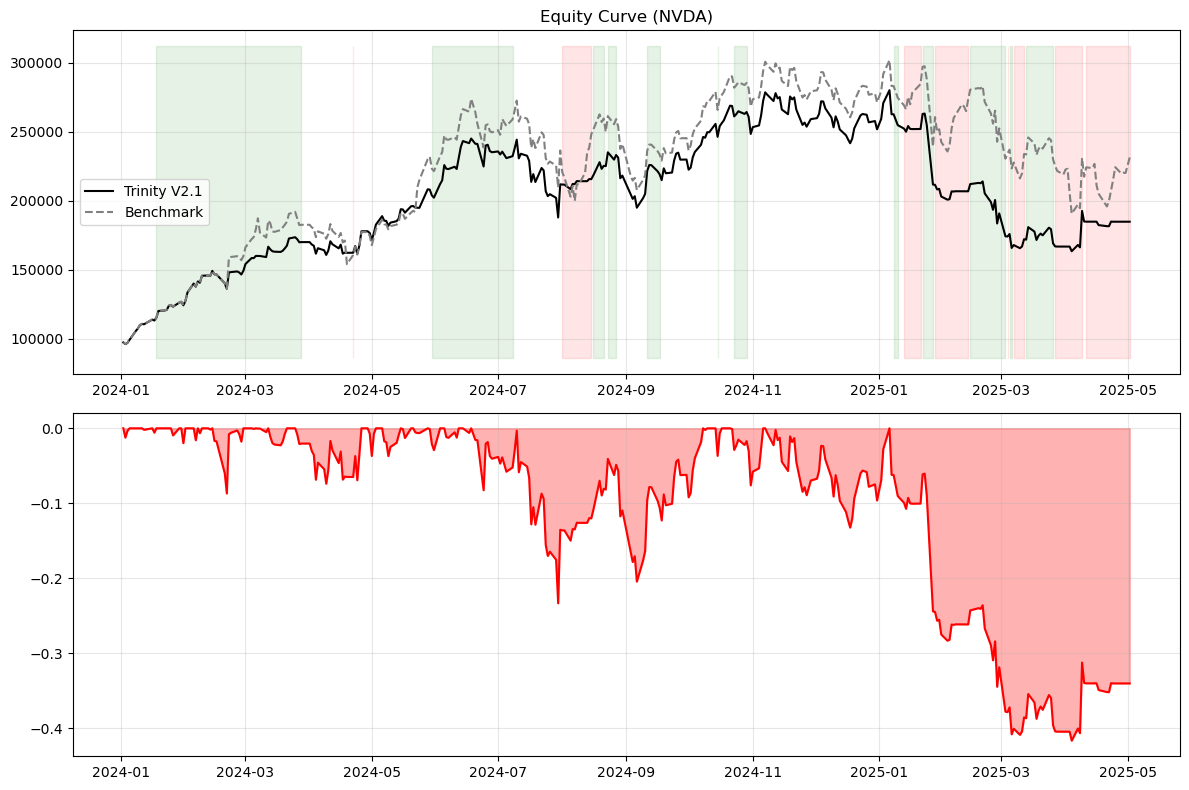

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURATION V2.1 (ROBUST) ---
DEFAULT_CONFIG = {
    # Assets
    "TICKERS": ["SPY", "QQQ", "^VIX", "SHY"], 
    "TARGET_ASSET": "SPY",
    
    # Dates
    "TRAIN_START": "2015-01-01",
    "TRAIN_END": "2023-12-31",
    "TEST_START": "2024-01-02",
    "TEST_END": "2025-05-05",
    
    # Crisis Training Periods
    "CRISIS_PERIODS": [
        ("2018-10-01", "2019-01-01"), 
        ("2020-02-01", "2020-05-01"), 
        ("2022-01-01", "2022-12-31"),
    ],
    
    # Adaptive Parameters
    "LOOKBACK_WINDOW": 60,
    "REGIME_SENSITIVITY": 1.0,   # Increased from 0.5 to reduce noise
    
    # RL Params
    "LEARNING_RATE": 3e-4,
    "BATCH_SIZE": 64,
    "TRAINING_STEPS": 60000, 
    "INITIAL_BALANCE": 100000,
    "FEES": 0.001,
    "MAX_LEVERAGE": 1.0, 
    "LONG_ONLY": False
}

# --- DATA PROCESSOR ---
class AdaptiveDataProcessor:
    def __init__(self, tickers, config):
        self.tickers = list(set(tickers))
        self.config = config
        
    def download(self, start, end):
        try:
            target = self.config['TARGET_ASSET']
            if target not in self.tickers: self.tickers.append(target)
                
            print(f"Fetching data for: {self.tickers}")
            data = yf.download(self.tickers, start=start, end=end, progress=False)
            
            # Handle yfinance multi-index
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]: data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]: data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]: data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series): data = data.to_frame()
            if target not in data.columns: data.columns = [target]
            
            # Get Volume
            ohlc = yf.download(target, start=start, end=end, progress=False)
            if 'Volume' not in data.columns:
                data['Volume'] = ohlc['Volume'] if 'Volume' in ohlc.columns else 1.0
                
            return data, ohlc
        except Exception as e:
            print(f"Data Error: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def add_features(self, df, ohlc):
        target = self.config['TARGET_ASSET']
        if df.empty: return pd.DataFrame()
        
        df = df.copy()
        
        # 1. Basic Returns
        df['returns'] = df[target].pct_change().fillna(0)
        df['log_ret'] = np.log1p(df['returns'])
        
        # 2. Volatility (Realized)
        df['vol_20'] = df['log_ret'].rolling(20).std() * np.sqrt(252)
        
        # 3. Bollinger Bands (Relative)
        sma20 = df[target].rolling(20).mean()
        std20 = df[target].rolling(20).std()
        df['bb_upper'] = sma20 + 2*std20
        df['bb_lower'] = sma20 - 2*std20
        df['pct_b'] = (df[target] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / sma20
        
        # 4. ADX (Trend Strength)
        high = ohlc['High'] if 'High' in ohlc.columns else df[target]
        low = ohlc['Low'] if 'Low' in ohlc.columns else df[target]
        close = ohlc['Close'] if 'Close' in ohlc.columns else df[target]
        
        df['tr'] = np.maximum(high - low, np.maximum(abs(high - close.shift(1)), abs(low - close.shift(1))))
        df['dm_plus'] = np.where((high - high.shift(1)) > (low.shift(1) - low), np.maximum(high - high.shift(1), 0), 0)
        df['dm_minus'] = np.where((low.shift(1) - low) > (high - high.shift(1)), np.maximum(low.shift(1) - low, 0), 0)
        
        window = 14
        df['tr_s'] = df['tr'].rolling(window).mean()
        df['dp_s'] = df['dm_plus'].rolling(window).mean()
        df['dm_s'] = df['dm_minus'].rolling(window).mean()
        df['dx'] = 100 * abs(df['dp_s'] - df['dm_s']) / (df['dp_s'] + df['dm_s'] + 1e-9)
        df['adx'] = df['dx'].rolling(window).mean().fillna(0)

        # 5. Distance from Long Term SMAs
        df['dist_sma50'] = (df[target] / df[target].rolling(50).mean()) - 1
        df['dist_sma200'] = (df[target] / df[target].rolling(200).mean()) - 1
        
        # 6. Lee-Mykland (Jump)
        log_ret = np.log(df[target] / df[target].shift(1))
        bv = (abs(log_ret) * abs(log_ret.shift(1))).rolling(20).mean() * (np.pi/2)
        local_vol = np.sqrt(bv)
        df['l_stat'] = log_ret / (local_vol + 1e-9)

        # --- ADAPTIVE NORMALIZATION (Z-Scores) ---
        lookback = self.config['LOOKBACK_WINDOW']
        
        def rolling_z_score(series, window):
            mean = series.rolling(window).mean()
            std = series.rolling(window).std()
            return (series - mean) / (std + 1e-9)

        df['adx_z'] = rolling_z_score(df['adx'], lookback)
        df['vol_z'] = rolling_z_score(df['vol_20'], lookback)
        df['volume_z'] = rolling_z_score(df['Volume'], lookback)
        
        return df.fillna(0)

    def get_data(self, start, end):
        df, ohlc = self.download(start, end)
        return self.add_features(df, ohlc)

    def get_crisis_data(self):
        dfs = []
        for s, e in self.config['CRISIS_PERIODS']:
            d, o = self.download(s, e)
            dfs.append(self.add_features(d, o))
        return pd.concat(dfs).reset_index(drop=True).fillna(0)

# --- ENVIRONMENT ---
class AdaptiveTradingEnv(gym.Env):
    def __init__(self, df, config, mode='trend'):
        super().__init__()
        self.df = df
        self.config = config
        self.mode = mode 
        self.window = config['LOOKBACK_WINDOW']
        self.data = df.values.astype(np.float32)
        self.n_features = df.shape[1]
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window * self.n_features,), dtype=np.float32)
        self.current_step = self.window
        
        self.cols = df.columns.tolist()
        self.idx_ret = self.cols.index('returns')
        self.idx_pct_b = self.cols.index('pct_b') if 'pct_b' in self.cols else -1
        self.idx_sma200 = self.cols.index('dist_sma200') if 'dist_sma200' in self.cols else -1

    def reset(self, seed=None, options=None):
        self.current_step = self.window + np.random.randint(0, 50)
        if self.current_step >= len(self.df): self.current_step = self.window
        return self._get_obs(), {}
    
    def _get_obs(self):
        return self.data[self.current_step-self.window : self.current_step].flatten()

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, False, {}
            
        act = np.clip(action[0], -1, 1)
        ret = self.data[self.current_step, self.idx_ret]
        
        # --- FIXED REWARD FUNCTIONS ---
        reward = 0
        
        if self.mode == 'trend':
            # Simple Trend Reward: PnL + Holding Bias in Uptrends
            reward = act * ret * 100
            sma_dist = self.data[self.current_step, self.idx_sma200]
            if sma_dist > 0 and act > 0: reward += 0.05
            
        elif self.mode == 'accumulation':
            # PnL only. Removed the "Middle Band" penalty.
            # We want the agent to learn to hold through noise.
            reward = act * ret * 100
            
            # Simple penalty for being short in a bull market context
            sma_dist = self.data[self.current_step, self.idx_sma200]
            if sma_dist > 0.10 and act < 0: reward -= 0.1

        elif self.mode == 'crisis':
            # Panic Defense
            reward = act * ret * 100
            if ret < -0.02 and act > 0.1: reward -= 5.0 # Punish getting caught
            if ret < -0.02 and act < -0.1: reward += 2.0 # Reward protection
                
        self.current_step += 1
        return self._get_obs(), reward, False, False, {}

# --- MANAGER ---
class TrinityManagerV2:
    def __init__(self, config):
        self.config = config
        self.dp = AdaptiveDataProcessor(config['TICKERS'], config)
        self.agents = {}
        self.envs = {}
        
    def train(self):
        print("\n=== TRAINING SPECIALISTS (V2.1 ROBUST) ===")
        trend_data = self.dp.get_data(self.config['TRAIN_START'], self.config['TRAIN_END'])
        crisis_data = self.dp.get_crisis_data()
        
        for mode in ['trend', 'accumulation', 'crisis']:
            data = crisis_data if mode == 'crisis' else trend_data
            env = DummyVecEnv([lambda: AdaptiveTradingEnv(data, self.config, mode=mode)])
            env = VecNormalize(env, norm_obs=True, norm_reward=False, gamma=0.99)
            
            model = PPO("MlpPolicy", env, verbose=0, learning_rate=self.config['LEARNING_RATE'])
            model.learn(total_timesteps=self.config['TRAINING_STEPS'])
            
            self.agents[mode] = model
            self.envs[mode] = env
            
        print("Training Complete.")

    def backtest(self, start, end):
        print(f"\n=== STARTING BACKTEST ({start} to {end}) ===")
        warmup_start = (pd.to_datetime(start) - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
        df = self.dp.get_data(warmup_start, end)
        
        test_mask = (df.index >= start) & (df.index <= end)
        test_df = df[test_mask]
        
        if test_df.empty: return
        
        portfolio = self.config['INITIAL_BALANCE']
        benchmark = self.config['INITIAL_BALANCE']
        holdings = 0
        history = []
        
        vals = df.values
        idx_map = {c: i for i, c in enumerate(df.columns)}
        
        start_idx = np.where(df.index == test_df.index[0])[0][0]
        end_idx = np.where(df.index == test_df.index[-1])[0][0]
        
        print(f"{'Date':<12} | {'Regime':<15} | {'Agent':<12} | {'Action':<6} | {'Portfolio':<10}")
        print("-" * 70)
        
        for t in range(start_idx, end_idx + 1):
            current_date = df.index[t]
            
            # --- FIX: ROBUST REGIME DETECTION ---
            adx_z = vals[t-1, idx_map['adx_z']]
            vol_z = vals[t-1, idx_map['vol_z']]
            l_stat = vals[t-1, idx_map['l_stat']]
            dist_sma50 = vals[t-1, idx_map['dist_sma50']]
            dist_sma200 = vals[t-1, idx_map['dist_sma200']]
            
            # A Bull Market with High Volatility is "MANIC", NOT "CRISIS".
            # Crisis = High Volatility AND (Down Trend OR Crash Signature)
            
            is_high_vol = (vol_z > 1.5)
            is_crash_sig = (l_stat < -3.0) or (dist_sma200 < -0.10)
            is_downtrend = (dist_sma50 < 0)
            
            regime = "NEUTRAL"
            
            if is_crash_sig or (is_high_vol and is_downtrend):
                regime = "CRISIS"
                agent_name = "crisis"
            elif (adx_z > 0.2) or (is_high_vol and not is_downtrend):
                # High Vol + Uptrend = Trend Following (Manic Phase)
                regime = "TREND"
                agent_name = "trend"
            else:
                regime = "ACCUMULATION"
                agent_name = "accumulation"
            
            # --- AGENT PREDICTION ---
            obs_raw = vals[t - self.config['LOOKBACK_WINDOW'] : t].flatten()
            env = self.envs[agent_name]
            obs_norm = env.normalize_obs(obs_raw)
            
            action, _ = self.agents[agent_name].predict(obs_norm, deterministic=True)
            raw_act = np.clip(action[0], -1, 1)
            
            if self.config['LONG_ONLY']:
                raw_act = max(0, raw_act)
            
            # Global Safety: Only exit if catastrophic loss of momentum
            if dist_sma200 < -0.25 and agent_name != 'crisis':
                raw_act = 0.0

            # --- EXECUTION ---
            ret = vals[t, idx_map['returns']]
            target_pos = raw_act * self.config['MAX_LEVERAGE']
            
            trade_cost = abs(target_pos - holdings) * self.config['FEES']
            holdings = target_pos
            
            daily_pnl = (holdings * ret * portfolio) - (trade_cost * portfolio)
            portfolio += daily_pnl
            benchmark *= (1 + ret)
            
            history.append({
                'Date': current_date,
                'Portfolio': portfolio,
                'Benchmark': benchmark,
                'Regime': regime,
                'Action': raw_act
            })
            
            if t % 20 == 0:
                 print(f"{str(current_date.date()):<12} | {regime:<15} | {agent_name:<12} | {raw_act:>6.2f} | {portfolio:>10.0f}")

        res = pd.DataFrame(history).set_index('Date')
        total_ret = (res['Portfolio'].iloc[-1] / self.config['INITIAL_BALANCE']) - 1
        bench_ret = (res['Benchmark'].iloc[-1] / self.config['INITIAL_BALANCE']) - 1
        
        print("-" * 70)
        print(f"Final Return: {total_ret:.2%}")
        print(f"Benchmark:    {bench_ret:.2%}")
        print(f"Alpha:        {total_ret - bench_ret:.2%}")
        
        self.plot_results(res)

    def plot_results(self, df):
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(df.index, df['Portfolio'], label='Trinity V2.1', color='k')
        plt.plot(df.index, df['Benchmark'], label='Benchmark', color='gray', linestyle='--')
        plt.title(f"Equity Curve ({self.config['TARGET_ASSET']})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        y_min, y_max = plt.ylim()
        plt.fill_between(df.index, y_min, y_max, where=(df['Regime'] == 'TREND'), color='green', alpha=0.1, label='Trend')
        plt.fill_between(df.index, y_min, y_max, where=(df['Regime'] == 'CRISIS'), color='red', alpha=0.1, label='Crisis')
        
        plt.subplot(2, 1, 2)
        peak = df['Portfolio'].cummax()
        dd = (df['Portfolio'] - peak) / peak
        plt.plot(df.index, dd, color='red', label='Drawdown')
        plt.fill_between(df.index, dd, 0, color='red', alpha=0.3)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    target_ticker = "NVDA"
    config = DEFAULT_CONFIG.copy()
    config['TARGET_ASSET'] = target_ticker
    
    if target_ticker not in ["SPY", "QQQ", "IWM"]:
        config['LONG_ONLY'] = True 
        config['MAX_LEVERAGE'] = 1.0 
        
    mgr = TrinityManagerV2(config)
    mgr.train()
    mgr.backtest("2024-01-02", "2025-05-05")


=== TRAINING SPECIALISTS (V3 ANTI-FRAGILE) ===
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Training Complete.

=== STARTING BACKTEST (2024-01-02 to 2025-05-05) ===
Fetching data for: ['SHY', 'QQQ', '^VIX', 'SPY', 'NVDA']
Date         | Regime          | Agent        | Action | Portfolio 
----------------------------------------------------------------------
2024-01-23   | BEAR_RALLY      | trend        |   0.49 |     102776
2024-02-21   | BEAR_CRISIS     | crisis       |   0.00 |     118989
2024-03-20   | BEAR_CRISIS     | crisis       |   0.00 |     130442
2024-04-18   | BULL_ACCUM      | accumulation |   0.30 |     130263
2024-05-16   | BULL_ACCUM      | accumulation |   0.30 |     133270
2024-06-14   | BULL_TREND      | trend        |   0.44 |     168473
2024-07-16   | BULL_ACCUM      | accumulation |

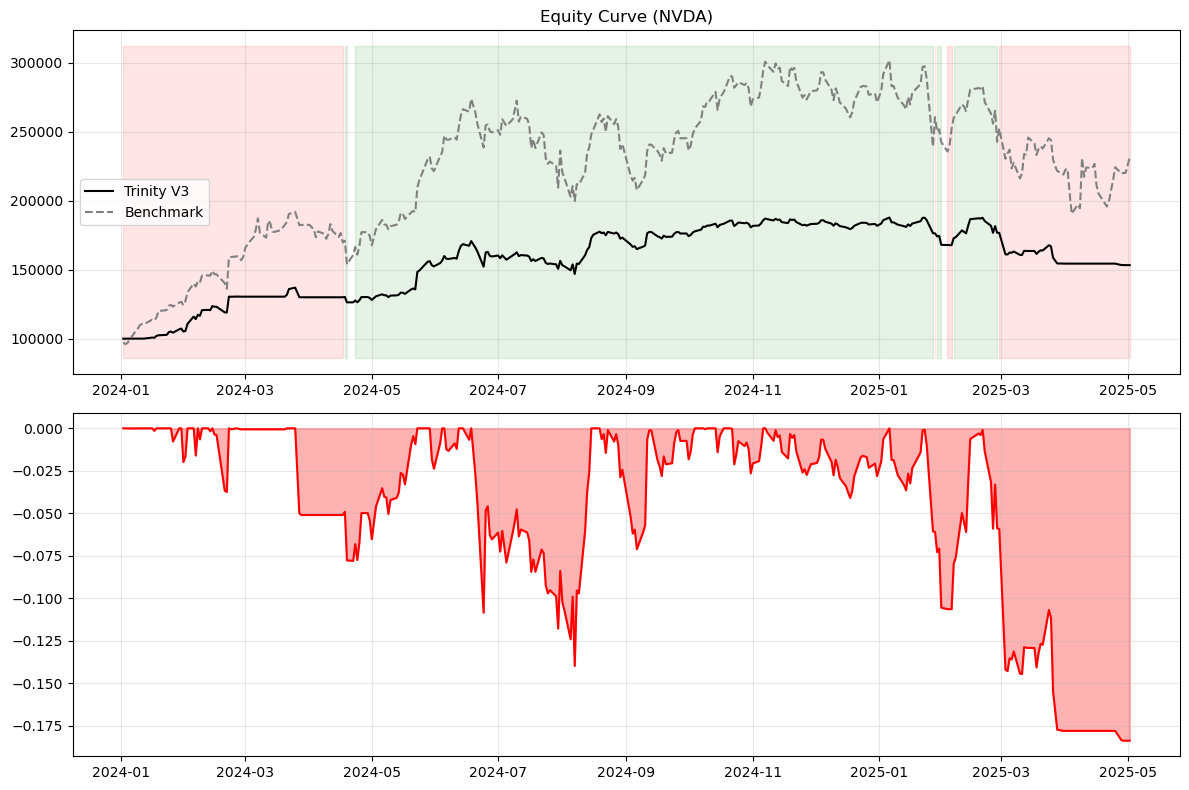

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURATION V3 (ANTI-FRAGILE) ---
DEFAULT_CONFIG = {
    # Assets
    "TICKERS": ["SPY", "QQQ", "^VIX", "SHY"], 
    "TARGET_ASSET": "SPY",
    
    # Dates
    "TRAIN_START": "2015-01-01",
    "TRAIN_END": "2023-12-31",
    "TEST_START": "2024-01-02",
    "TEST_END": "2025-05-05",
    
    # Crisis Training Periods (EXTENDED TO INCLUDE RECOVERIES)
    # We must teach the agent that crashes are followed by bounces.
    "CRISIS_PERIODS": [
        ("2018-10-01", "2019-06-01"), # Volmageddon + V-Shape Recovery
        ("2020-02-01", "2020-09-01"), # COVID Crash + Fed Pump
        ("2022-01-01", "2023-01-01"), # 2022 Bear Market
    ],
    
    # Adaptive Parameters
    "LOOKBACK_WINDOW": 60,
    "REGIME_SENSITIVITY": 1.2,
    
    # RL Params
    "LEARNING_RATE": 3e-4,
    "BATCH_SIZE": 128,          # Larger batch size for more stable gradients
    "TRAINING_STEPS": 80000,    # Increased training steps
    "INITIAL_BALANCE": 100000,
    "FEES": 0.001,
    "MAX_LEVERAGE": 1.0, 
    "LONG_ONLY": False
}

# --- DATA PROCESSOR ---
class AdaptiveDataProcessor:
    def __init__(self, tickers, config):
        self.tickers = list(set(tickers))
        self.config = config
        
    def download(self, start, end):
        try:
            target = self.config['TARGET_ASSET']
            if target not in self.tickers: self.tickers.append(target)
                
            print(f"Fetching data for: {self.tickers}")
            data = yf.download(self.tickers, start=start, end=end, progress=False)
            
            # Handle yfinance multi-index
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]: data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]: data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]: data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series): data = data.to_frame()
            if target not in data.columns: data.columns = [target]
            
            # Get Volume
            ohlc = yf.download(target, start=start, end=end, progress=False)
            if 'Volume' not in data.columns:
                data['Volume'] = ohlc['Volume'] if 'Volume' in ohlc.columns else 1.0
                
            return data, ohlc
        except Exception as e:
            print(f"Data Error: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def add_features(self, df, ohlc):
        target = self.config['TARGET_ASSET']
        if df.empty: return pd.DataFrame()
        
        df = df.copy()
        
        # 1. Basic Returns
        df['returns'] = df[target].pct_change().fillna(0)
        df['log_ret'] = np.log1p(df['returns'])
        
        # 2. Volatility (Realized)
        df['vol_20'] = df['log_ret'].rolling(20).std() * np.sqrt(252)
        
        # 3. Bollinger Bands (Relative)
        sma20 = df[target].rolling(20).mean()
        std20 = df[target].rolling(20).std()
        df['bb_upper'] = sma20 + 2*std20
        df['bb_lower'] = sma20 - 2*std20
        df['pct_b'] = (df[target] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / sma20
        
        # 4. ADX (Trend Strength)
        high = ohlc['High'] if 'High' in ohlc.columns else df[target]
        low = ohlc['Low'] if 'Low' in ohlc.columns else df[target]
        close = ohlc['Close'] if 'Close' in ohlc.columns else df[target]
        
        df['tr'] = np.maximum(high - low, np.maximum(abs(high - close.shift(1)), abs(low - close.shift(1))))
        df['dm_plus'] = np.where((high - high.shift(1)) > (low.shift(1) - low), np.maximum(high - high.shift(1), 0), 0)
        df['dm_minus'] = np.where((low.shift(1) - low) > (high - high.shift(1)), np.maximum(low.shift(1) - low, 0), 0)
        
        window = 14
        df['tr_s'] = df['tr'].rolling(window).mean()
        df['dp_s'] = df['dm_plus'].rolling(window).mean()
        df['dm_s'] = df['dm_minus'].rolling(window).mean()
        df['dx'] = 100 * abs(df['dp_s'] - df['dm_s']) / (df['dp_s'] + df['dm_s'] + 1e-9)
        df['adx'] = df['dx'].rolling(window).mean().fillna(0)

        # 5. Distance from Long Term SMAs
        df['dist_sma50'] = (df[target] / df[target].rolling(50).mean()) - 1
        df['dist_sma200'] = (df[target] / df[target].rolling(200).mean()) - 1
        
        # 6. Lee-Mykland (Jump)
        log_ret = np.log(df[target] / df[target].shift(1))
        bv = (abs(log_ret) * abs(log_ret.shift(1))).rolling(20).mean() * (np.pi/2)
        local_vol = np.sqrt(bv)
        df['l_stat'] = log_ret / (local_vol + 1e-9)

        # --- ADAPTIVE NORMALIZATION (Z-Scores) ---
        lookback = self.config['LOOKBACK_WINDOW']
        
        def rolling_z_score(series, window):
            mean = series.rolling(window).mean()
            std = series.rolling(window).std()
            return (series - mean) / (std + 1e-9)

        df['adx_z'] = rolling_z_score(df['adx'], lookback)
        df['vol_z'] = rolling_z_score(df['vol_20'], lookback)
        df['volume_z'] = rolling_z_score(df['Volume'], lookback)
        
        return df.fillna(0)

    def get_data(self, start, end):
        df, ohlc = self.download(start, end)
        return self.add_features(df, ohlc)

    def get_crisis_data(self):
        dfs = []
        for s, e in self.config['CRISIS_PERIODS']:
            d, o = self.download(s, e)
            dfs.append(self.add_features(d, o))
        return pd.concat(dfs).reset_index(drop=True).fillna(0)

# --- ENVIRONMENT ---
class AdaptiveTradingEnv(gym.Env):
    def __init__(self, df, config, mode='trend'):
        super().__init__()
        self.df = df
        self.config = config
        self.mode = mode 
        self.window = config['LOOKBACK_WINDOW']
        self.data = df.values.astype(np.float32)
        self.n_features = df.shape[1]
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window * self.n_features,), dtype=np.float32)
        self.current_step = self.window
        
        self.cols = df.columns.tolist()
        self.idx_ret = self.cols.index('returns')
        self.idx_pct_b = self.cols.index('pct_b') if 'pct_b' in self.cols else -1
        self.idx_sma200 = self.cols.index('dist_sma200') if 'dist_sma200' in self.cols else -1

    def reset(self, seed=None, options=None):
        self.current_step = self.window + np.random.randint(0, 50)
        if self.current_step >= len(self.df): self.current_step = self.window
        return self._get_obs(), {}
    
    def _get_obs(self):
        return self.data[self.current_step-self.window : self.current_step].flatten()

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, False, {}
            
        act = np.clip(action[0], -1, 1)
        ret = self.data[self.current_step, self.idx_ret]
        
        # --- IMPROVED REWARD FUNCTIONS ---
        reward = 0
        
        if self.mode == 'trend':
            # Trend Reward: PnL + Participation Bonus
            # We want the agent to be invested during trends, not sitting in cash
            reward = act * ret * 100
            if act > 0.5: reward += 0.01 # Small holding bonus
            
        elif self.mode == 'accumulation':
            # Accumulation Reward: Catching bottoms / buying dips
            reward = act * ret * 100
            
            # Bonus for buying when price is low (relative to SMA200)
            sma_dist = self.data[self.current_step, self.idx_sma200]
            if sma_dist > 0 and act > 0.2: 
                 # Buying the dip in a secular bull
                 reward += 0.05 

        elif self.mode == 'crisis':
            # Crisis Reward: Survival + Opportunity
            reward = act * ret * 100
            
            # Massive penalty for holding through a crash
            if ret < -0.03 and act > 0.2: reward -= 5.0 
            
            # BIG Bonus for re-entering (catching the bounce)
            if ret > 0.03 and act > 0.2: reward += 5.0
                
        self.current_step += 1
        return self._get_obs(), reward, False, False, {}

# --- MANAGER ---
class TrinityManagerV2:
    def __init__(self, config):
        self.config = config
        self.dp = AdaptiveDataProcessor(config['TICKERS'], config)
        self.agents = {}
        self.envs = {}
        
    def train(self):
        print("\n=== TRAINING SPECIALISTS (V3 ANTI-FRAGILE) ===")
        trend_data = self.dp.get_data(self.config['TRAIN_START'], self.config['TRAIN_END'])
        crisis_data = self.dp.get_crisis_data()
        
        for mode in ['trend', 'accumulation', 'crisis']:
            data = crisis_data if mode == 'crisis' else trend_data
            env = DummyVecEnv([lambda: AdaptiveTradingEnv(data, self.config, mode=mode)])
            env = VecNormalize(env, norm_obs=True, norm_reward=False, gamma=0.99)
            
            model = PPO("MlpPolicy", env, verbose=0, learning_rate=self.config['LEARNING_RATE'])
            model.learn(total_timesteps=self.config['TRAINING_STEPS'])
            
            self.agents[mode] = model
            self.envs[mode] = env
            
        print("Training Complete.")

    def backtest(self, start, end):
        print(f"\n=== STARTING BACKTEST ({start} to {end}) ===")
        warmup_start = (pd.to_datetime(start) - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
        df = self.dp.get_data(warmup_start, end)
        
        test_mask = (df.index >= start) & (df.index <= end)
        test_df = df[test_mask]
        
        if test_df.empty: return
        
        portfolio = self.config['INITIAL_BALANCE']
        benchmark = self.config['INITIAL_BALANCE']
        holdings = 0
        history = []
        
        vals = df.values
        idx_map = {c: i for i, c in enumerate(df.columns)}
        
        start_idx = np.where(df.index == test_df.index[0])[0][0]
        end_idx = np.where(df.index == test_df.index[-1])[0][0]
        
        print(f"{'Date':<12} | {'Regime':<15} | {'Agent':<12} | {'Action':<6} | {'Portfolio':<10}")
        print("-" * 70)
        
        for t in range(start_idx, end_idx + 1):
            current_date = df.index[t]
            
            # --- FEATURES ---
            adx_z = vals[t-1, idx_map['adx_z']]
            vol_z = vals[t-1, idx_map['vol_z']]
            l_stat = vals[t-1, idx_map['l_stat']]
            dist_sma50 = vals[t-1, idx_map['dist_sma50']]
            dist_sma200 = vals[t-1, idx_map['dist_sma200']]
            
            # --- SECULAR BULL FILTER (The "Wall St" Logic) ---
            # If price is > 200 SMA, we are in a Secular Bull Market.
            # In a Secular Bull, "High Volatility" usually means "Buying Opportunity", not "Crash".
            
            IS_SECULAR_BULL = (dist_sma200 > 0.0)
            
            regime = "NEUTRAL"
            
            if IS_SECULAR_BULL:
                # BULL MARKET LOGIC
                # Ignore Crisis Agent unless it's a Black Swan (l_stat extremely negative)
                if l_stat < -4.0:
                    regime = "FLASH_CRASH"
                    agent_name = "crisis"
                elif adx_z > 0.2:
                    regime = "BULL_TREND"
                    agent_name = "trend"
                else:
                    regime = "BULL_ACCUM" # Choppy/Consolidation in Bull
                    agent_name = "accumulation"
            else:
                # BEAR MARKET LOGIC (Standard Defensive)
                if (vol_z > 1.5) or (l_stat < -2.0):
                    regime = "BEAR_CRISIS"
                    agent_name = "crisis"
                elif adx_z > 0.5:
                    regime = "BEAR_RALLY" # Shorting opportunity or cash
                    agent_name = "trend"
                else:
                    regime = "BEAR_CHOP"
                    agent_name = "accumulation"
            
            # --- AGENT PREDICTION ---
            obs_raw = vals[t - self.config['LOOKBACK_WINDOW'] : t].flatten()
            env = self.envs[agent_name]
            obs_norm = env.normalize_obs(obs_raw)
            
            action, _ = self.agents[agent_name].predict(obs_norm, deterministic=True)
            raw_act = np.clip(action[0], -1, 1)
            
            # --- EXECUTION BIAS ---
            if self.config['LONG_ONLY']:
                # 1. Clip Negatives
                raw_act = max(0, raw_act)
                
                # 2. Bull Market Floor
                # If we are in a Secular Bull, we rarely want to be 0% invested.
                # If agent says 0.0, we force at least 0.3 (30%) exposure to catch drifts.
                if IS_SECULAR_BULL and raw_act < 0.3 and agent_name != "crisis":
                    raw_act = 0.3
            
            # Hard Stop Loss (Global Safety Net)
            # If we are excessively extended below SMA200, force exit.
            if dist_sma200 < -0.15 and agent_name != 'crisis':
                raw_act = 0.0

            # --- EXECUTION ---
            ret = vals[t, idx_map['returns']]
            target_pos = raw_act * self.config['MAX_LEVERAGE']
            
            trade_cost = abs(target_pos - holdings) * self.config['FEES']
            holdings = target_pos
            
            daily_pnl = (holdings * ret * portfolio) - (trade_cost * portfolio)
            portfolio += daily_pnl
            benchmark *= (1 + ret)
            
            history.append({
                'Date': current_date,
                'Portfolio': portfolio,
                'Benchmark': benchmark,
                'Regime': regime,
                'Action': raw_act
            })
            
            if t % 20 == 0:
                 print(f"{str(current_date.date()):<12} | {regime:<15} | {agent_name:<12} | {raw_act:>6.2f} | {portfolio:>10.0f}")

        res = pd.DataFrame(history).set_index('Date')
        total_ret = (res['Portfolio'].iloc[-1] / self.config['INITIAL_BALANCE']) - 1
        bench_ret = (res['Benchmark'].iloc[-1] / self.config['INITIAL_BALANCE']) - 1
        
        print("-" * 70)
        print(f"Final Return: {total_ret:.2%}")
        print(f"Benchmark:    {bench_ret:.2%}")
        print(f"Alpha:        {total_ret - bench_ret:.2%}")
        
        self.plot_results(res)

    def plot_results(self, df):
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(df.index, df['Portfolio'], label='Trinity V3', color='k')
        plt.plot(df.index, df['Benchmark'], label='Benchmark', color='gray', linestyle='--')
        plt.title(f"Equity Curve ({self.config['TARGET_ASSET']})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        y_min, y_max = plt.ylim()
        # Highlight Bull Regimes
        plt.fill_between(df.index, y_min, y_max, where=(df['Regime'].str.contains('BULL')), color='green', alpha=0.1, label='Secular Bull')
        # Highlight Bear/Crisis
        plt.fill_between(df.index, y_min, y_max, where=(df['Regime'].str.contains('BEAR') | df['Regime'].str.contains('CRISIS')), color='red', alpha=0.1, label='Bear/Crisis')
        
        plt.subplot(2, 1, 2)
        peak = df['Portfolio'].cummax()
        dd = (df['Portfolio'] - peak) / peak
        plt.plot(df.index, dd, color='red', label='Drawdown')
        plt.fill_between(df.index, dd, 0, color='red', alpha=0.3)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    target_ticker = "NVDA"
    config = DEFAULT_CONFIG.copy()
    config['TARGET_ASSET'] = target_ticker
    
    if target_ticker not in ["SPY", "QQQ", "IWM"]:
        config['LONG_ONLY'] = True 
        config['MAX_LEVERAGE'] = 1.0 
        
    mgr = TrinityManagerV2(config)
    mgr.train()
    mgr.backtest("2024-01-02", "2025-05-05")